In [1]:
import pymc3 as pm
import scipy as sp
import math

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import pandas as pd

In [ ]:
! pip install xlrd

In [304]:
florida = pd.read_csv("Case_Data.csv")

In [311]:
florida["Age"].mean()

50.763383488860114

In [4]:
florida=florida[["Gender","Age","Died"]]
florida=florida[florida["Age"].notna()]

In [5]:
florida["Died"] = florida["Died"].notna()*1

In [6]:
florida["Gender"]= (florida["Gender"]=="Male")*1

In [7]:
def age_to_age_category(age):
    return math.floor(age/5)

In [9]:
florida["Age Category"]= florida["Age"].apply(age_to_age_category)
florida= florida[["Gender","Age Category","Died"]]

In [10]:
florida = florida.groupby(['Gender', 'Age Category']).Died.agg(n=('size'),died=("sum") ).reset_index()

In [12]:
florida.head()

,Gender,Age Category,n,died
0,0,0,125,0
1,0,1,125,0
2,0,2,179,0
3,0,3,498,0
4,0,4,1307,0


### Multilevel Regression Model

$$\begin{align*}
\theta_i
    & = \beta_0 + \alpha^{\textrm{gender}}_{i} + \alpha^{\textrm{age}}_{i}\\
\log \left(\frac{p_i}{1 - p_i}\right)
    & = \theta_i \\
y_i
    & \sim \textrm{Bernoulli}(n_i, p_i)
\end{align*}$$


In [13]:
florida_age_categories = florida["Age Category"].values

In [14]:
florida_gender = florida["Gender"].values

In [44]:
florida_n = florida["n"].values

In [16]:
florida_deaths = florida["died"].values

In [301]:
(florida[florida["Gender"]==1]["died"]/florida[florida["Gender"]==1]["n"]).mean()

0.10505997087605502

In [299]:
(florida["died"]/florida["n"]).mean()

0.08327146323860705

In [88]:
with pm.Model() as model:
    β0 = pm.Normal('β0', 0., 5.,testval=sp.special.logit((florida["died"]/florida["n"]).mean()))
    a_gender = pm.Normal('a_gender', 0., 5., testval=sp.special.logit(0.1))
    a_age = pm.Normal("a_age", 0., 5., testval=sp.special.logit(0.01))
    

    θ = pm.Deterministic("θ",β0 + a_gender * florida_gender + a_age * florida_age_categories)
    p = pm.math.sigmoid(θ)
    obs = pm.Binomial('obs', florida_n, p, observed=florida_deaths)

    

In [112]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(draws=20000, tune=10000,step=step)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [a_age]
>Metropolis: [a_gender]
>Metropolis: [β0]


Sampling 2 chains for 10_000 tune and 20_000 draw iterations (20_000 + 40_000 draws total) took 62 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


In [91]:
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [246]:
from random import randrange

def predict(gender, age, rand_num=False):
    if not rand_num:
        rand_num = randrange(len(trace))
    return sigmoid(trace["β0"][rand_num] + trace["a_age"][rand_num]*age_to_age_category(age) + trace["a_gender"][rand_num]*gender)

In [108]:
import matplotlib.pyplot as plt
%matplotlib inline


(array([ 253., 1565., 5751., 9897., 9654., 6889., 4200., 1433.,  314.,
          44.]),
 array([0.39966684, 0.40555356, 0.41144029, 0.41732701, 0.42321374,
        0.42910046, 0.43498719, 0.44087391, 0.44676064, 0.45264736,
        0.45853409]),
 <a list of 10 Patch objects>)

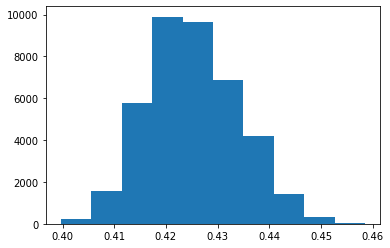

In [114]:
plt.hist(trace["a_age"])

(array([   46.,   379.,  2350.,  6931., 11457., 11108.,  5700.,  1715.,
          286.,    28.]),
 array([0.41956944, 0.45823881, 0.49690818, 0.53557755, 0.57424692,
        0.61291629, 0.65158566, 0.69025503, 0.7289244 , 0.76759377,
        0.80626314]),
 <a list of 10 Patch objects>)

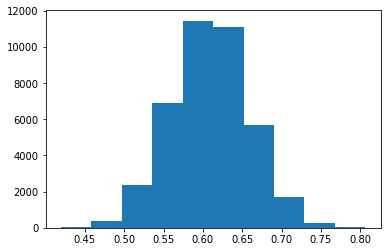

In [285]:
plt.hist(trace["a_gender"])

(array([  90.,  595., 1944., 4664., 7062., 9790., 9019., 5056., 1514.,
         266.]),
 array([-9.16635192, -9.07877787, -8.99120383, -8.90362978, -8.81605573,
        -8.72848169, -8.64090764, -8.55333359, -8.46575955, -8.3781855 ,
        -8.29061145]),
 <a list of 10 Patch objects>)

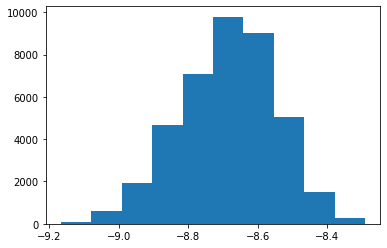

In [290]:
plt.hist(trace["β0"])

In [189]:
abs_stats = pd.read_excel("3101059.xls", sheet_name="Data1")

In [190]:
col_names =  ['Gender', 'Age', 'n']
australia  = pd.DataFrame(columns = col_names)
australia


,Gender,Age,n


In [191]:
for i, n in enumerate(abs_stats.iloc[56][1:102]):
    australia.loc[i] = [1,i, n]

for i, n in enumerate(abs_stats.iloc[56][102:203]):
    australia.loc[i+101] = [0,i,n]


In [316]:
(australia["Age"]*australia["n"]).sum()/australia["n"].sum()

38.36885289160091

In [209]:
import numpy as np

In [280]:
iterations=[]
for _ in range(1000):
    deaths=[]
    for i, row in australia.iterrows():
        seed = randrange(len(trace))
        age_gender_deaths = np.random.binomial(row["n"],predict(row["Gender"],row["Age"], seed))
        deaths.append(age_gender_deaths)
    iterations.append(sum(deaths))

In [279]:
sum(deaths)

625262

In [294]:
print("Average number of Australian deaths for 100% infections according to MRP:")
sum(iterations)/len(iterations)

Average number of Australian deaths for 100% infections according to MRP:


626167.587

(array([  5.,  31.,  79., 148., 231., 233., 160.,  86.,  21.,   6.]),
 array([619220. , 620609.1, 621998.2, 623387.3, 624776.4, 626165.5,
        627554.6, 628943.7, 630332.8, 631721.9, 633111. ]),
 <a list of 10 Patch objects>)

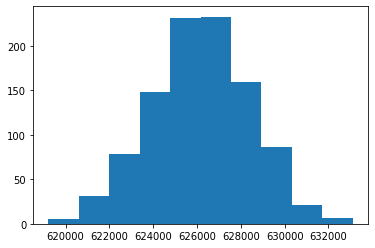

In [284]:
plt.hist(iterations)

In [297]:
print("Florida CFR * Australian population:")

florida["died"].sum()/florida["n"].sum()*australia["n"].sum()


Florida CFR * Australian population:


1138215.0261195695